# Assignment 1
Manjyot Singh Nanra <br>
21111038

Importing Required Libraries
- opencv 
- scipy
- PIL
- etc

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import math
from PIL import Image, ImageDraw
import random
import time

# Question 1

Constructing a Rectangle

- We will be using PIL Library of python to manipulate images and draw objects.
- We will have a function which returns rectangle co-ordinates given midpoint and side length
- This will be useful in question 2 too

In [34]:
def get_rectangle_co_ordinates(midpoint:tuple, side_len:int):
    p1 = (midpoint[0] - side_len/2, midpoint[1]-side_len/2)
    p2 = (midpoint[0] + side_len/2, midpoint[1] + side_len/2)

    return [p1, p2]

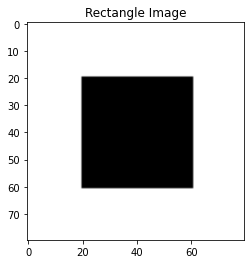

In [35]:
# REFERENCE: https://www.geeksforgeeks.org/python-pil-imagedraw-draw-rectangle/

box_shape = [80, 80] # Size of image
rectangle_midpoint, rectangle_side = (40,40), 40
rectangle_co_ordinates = get_rectangle_co_ordinates(rectangle_midpoint, rectangle_side)
rectangle_img = Image.new("L", box_shape,color="white")
drawobj = ImageDraw.Draw(rectangle_img)
drawobj.rectangle(rectangle_co_ordinates, fill="black")

rectangle_data= np.asarray(rectangle_img, dtype=float)  # converting to numpy array for future use
plt.imshow(rectangle_data, cmap="gray")
plt.title("Rectangle Image")
plt.show()

Constructing a Triangle

- Similar to rectangle, we generate a triangle image
- Note that the triangle will be equilateral triangle

In [36]:
def get_triangle_co_ordinates(midpoint:tuple, side_len:int):
    """Give midpoint and side length as input and gives co-ordinates as output

    Args:
        midpoint (tuple): Tuple point containing (x, y) midpoint
        side_len (int): Length of side of equilateral triangle

    Returns:
        list: Returns list of 3 tuple points of triangle
    """
    height = side_len*math.sqrt(3)/2
    p1_X = midpoint[0] - side_len/2
    p1_Y = midpoint[1] - height/2
    p1 = (p1_X, p1_Y)

    p2_X = midpoint[0] + side_len/2
    p2_Y = p1_Y
    p2 = (p2_X, p2_Y)

    p3_X = midpoint[0]
    p3_Y = midpoint[1] + height/2
    p3 = (p3_X, p3_Y)

    return [p1, p2, p3]

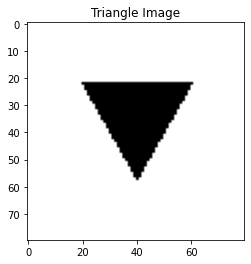

In [37]:
triangle_midpoint, side = (40, 40) , 40
triangle_co_ordinates = get_triangle_co_ordinates(triangle_midpoint, side)
triangle_img = Image.new("L", box_shape,color="white")
draw_obj = ImageDraw.Draw(triangle_img)
draw_obj.polygon(triangle_co_ordinates, fill="black")

triangle_data = np.asarray(triangle_img, dtype=float) # converting to numpy array for future use
plt.imshow(triangle_data, cmap="gray")
plt.title("Triangle Image")
plt.show()

- Now we will start defining functions that returns gabor filter given parameters
- Gabor filter can approximate characteristics of certain cells in the visual cortex of some mammals
- Gabor Filter equation is given as follow:<br>
<img src="gabor_formula.jpg" alt="Gabor filter Image" style="width: 500px;"/>
- Here $\lambda$ : wavelength of the sinusoidal component
- $\theta$ : orientation of the normal to the parallel stripes of Gabor function
- $\Psi$ : phase offset of sinusoidal function
- $\sigma$ : Standard deviation of gaussian
- $\gamma$ : Aspect ratio
- [REF](https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97)


In [38]:
# REFERENCE: https://en.wikipedia.org/wiki/Gabor_filter
# Code referred from above link
def getGaborFilter(filter_size, sigma, theta, lambd, gamma, psi):
    sigma_X, sigma_Y = sigma, float(sigma)/gamma

    # Bounding box, with min and max co-ordinates
    x_max, y_max = filter_size/2, filter_size/2
    x_min, y_min = -x_max, -y_max

    (y, x) = np.meshgrid(np.arange(y_min, y_max + 1), np.arange(x_min, x_max + 1))  #returns co-ordinate matrices

    # Rotation of filter using theta factor
    xTheta = x*np.cos(theta) + y*np.sin(theta)
    yTheta = -x*np.sin(theta) + y*np.cos(theta)


    filter = np.exp(-.5 * (xTheta ** 2 / sigma_X ** 2 + yTheta ** 2 / sigma_Y ** 2)) * np.cos(2 * np.pi / lambd * xTheta + psi)
    return filter

- Next, we define a function to create bank of filters
- Given a range of theta values and other required values, this function will return Gabor filter for each orientation
- This can be used to detect edges of different orientation

In [39]:
def createFilterBank(filter_size, sigma, theta_range, lambd, gamma, psi):
    filters = []
    for theta in theta_range:  # Theta is the orientation for edge detection
        filter = getGaborFilter(filter_size, sigma, theta, lambd, gamma, psi)
        filters.append(filter)
    return filters


- Defining a function which applies gabor bank of filters to a image 
- It returns the edges that filter detects 

In [40]:
# REFERENCE: https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/
def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
     
    for filter in filters:  # Loop through the filters in our GaborFilter
        filtered_output = ndi.convolve(img, filter, mode="wrap")
        plt.imshow(filtered_output)
        plt.show()
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, filtered_output, newimage)
    return newimage


In [41]:
# filter_size = 10 # The local area to evaluate
# sigma = 1.0 # Larger Values produce more edges
# lambd = 2
# gamma = 1
# psi = 0  # Offset value - lower generates cleaner results
# rectangle_theta_range = [0, np.pi/3, -np.pi/3]
# #rectangle_theta_range = [0, np.pi/2]
# rectangle_gfilters = createFilterBank(filter_size, sigma, rectangle_theta_range, lambd, gamma, psi)
# fil = cv2.filter2D(triangle_data, -1,rectangle_gfilters[1])
# fil[fil<190] = 0
# plt.imshow(fil, cmap="gray")

- Defining function to recognize rectangle for image on which we apply gabor filter
- For recognizing rectangle, we will make gabor filter with theta orientation at 0 degree and 90 degree. 
- We check whether we have enough edge activation value by taking mean of pixel values of output
- If for each filter, we pass the threshold value, it would mean that Image is a rectangle
- For example, a triangle will not produce edges when passed through filter of theta=pi/2(90 degrees)

In [42]:
def recognizeRectangle(image_data,plot=False, threshold=0.5):
    newimage = np.zeros_like(image_data)
    filter_size = 10  # The local area to evaluate
    sigma = 1.0  # Larger Values produce more edges
    lambd = 2
    gamma = 1
    psi = 0  # Offset value - lower generates cleaner results
    rectangle_theta_range = [0,np.pi/2]
    rectangle_gfilters = createFilterBank(filter_size, sigma, rectangle_theta_range, lambd, gamma, psi)
    
    filter_activation = np.zeros(len(rectangle_gfilters))

    for idx, filter in enumerate(rectangle_gfilters):
        filtered_image = cv2.filter2D(image_data, -1, filter)
        filtered_image[filtered_image<190] = 0
        np.maximum(newimage, filtered_image, newimage)
        if filtered_image.mean() > threshold:
            filter_activation[idx] = 1
    if plot:
        plt.title("After applying Rectangle Filter")
        plt.imshow(newimage, cmap="gray")
        plt.show()

    # This part checks that whether all theta range are satisfied and produces an edge
    if np.all(filter_activation):
        return True, newimage
    else:
        return False, newimage

- Similar to the recognize rectangle function
- Here the theta values will be 0, 60, 120 degrees

In [43]:
def recognizeTriangle(image_data, plot=False, threshold=0.5):
    newimage = np.zeros_like(image_data)
    filter_size = 10  # The local area to evaluate
    sigma = 1.0 # Larger Values produce more edges
    lambd = 2.5
    gamma = 1.0
    psi = 0  # Offset value - lower generates cleaner results
    triangle_theta_range = [0, np.pi/3, -np.pi/3]
    triangle_gfilters = createFilterBank(filter_size, sigma, triangle_theta_range, lambd, gamma, psi)

    filter_activation = np.zeros(len(triangle_gfilters))

    for idx, filter in enumerate(triangle_gfilters):
        filtered_image = cv2.filter2D(image_data, -1, filter)
        filtered_image[filtered_image < 180] = 0
        np.maximum(newimage, filtered_image, newimage)

        if filtered_image.mean() > threshold:
            filter_activation[idx] = 1

    if plot:
        plt.title("After applying Triangle Filter")
        plt.imshow(newimage, cmap="gray")
        plt.show()

    if np.all(filter_activation):
        return True, newimage 
    else:
        return False, newimage  

- Now we define an upper level "Complex Cell" function
- This function will recognize given a shape, whether it is rectangle, triangle or neither

In [44]:
def ComplexCell(image_data, plot=False):
    op, img = recognizeRectangle(image_data,plot=plot)
    if op:
        return "Rectangle", img
    op, img = recognizeTriangle(image_data, plot=plot)
    if op:
        return "Triangle", img
    
    return None, img
    

Testing out the complex cell

In [45]:
# CASE 1: Rectangle
plt.title("Original Image")
plt.imshow(rectangle_data, cmap="gray")
plt.show()

output = ComplexCell(rectangle_data, plot=True)[0]
print("The shape is:",output)


The shape is: Rectangle


Note that since shape rectangle is detected, it doesnt applies filter for Triangle filter

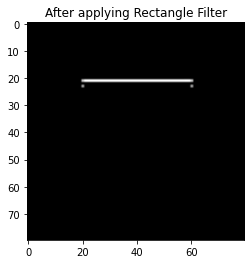

The shape is: Triangle


In [46]:
# CASE 2: Triangle
plt.title("Original Image")
plt.imshow(triangle_data, cmap="gray")
plt.show()

output = ComplexCell(triangle_data, plot=True)[0]
print("The shape is:",output)

Thus we have succesfully designed a complex cell that recognizes triangles and squares

# Question 2

- For question 2, we need to simulate visual search paradigm of Triesman
- This paradigm consists of finding odd stimulus in a set of objects.
- Under this paradigm, there are two types of searching
1) Feature Search: In this, task is to find target amongst the distractors, that will differ from target by a unique feature such as color or shape
2) Conjunction Search: In conjunction search, task is to find target surrounded by distractors possessing no distinct features from the target.

[REF](https://en.wikipedia.org/wiki/Visual_search)

- We will try to generate images for both types of search.
- For this we will imagine image as a grid and objects will lie in that gridded image

In [47]:
# Getting a blank canvas
def get_blank_image(box_size=800):
    return Image.new("RGB", (box_size, box_size), "white")

In [48]:
# Generating a list that will contain midpoint of hypothetical grid
def get_grid_points():
    grid_points = []

    for i in range(40, 800, 80):
        for j in range(40, 800, 80):
            grid_points.append((j, i))

    return grid_points


- We will now be defining function that generates an image for Feature search paradigm
- In this, we will have parameters to define stimulis features and distractors features and number of distractors
- This image will later be used in question 3 to detect odd stimulus

In [49]:
def feature_search_image_generator(
            stimuli_shape="rectangle", stimuli_color="blue", 
            distractor_shape="rectangle", distractor_color="red", 
            number_of_distractors=10
            ):

    feature_search_image = get_blank_image()
    grid_points = get_grid_points()

    stimuli_position = grid_points.pop(random.randrange(len(grid_points)))
    drawobj = ImageDraw.Draw(feature_search_image)
    if stimuli_shape == "rectangle":
        co_ordinates = get_rectangle_co_ordinates(stimuli_position, 60)
        drawobj.rectangle(co_ordinates, fill=stimuli_color)

    else:
        co_ordinates = get_triangle_co_ordinates(stimuli_position, 60)
        drawobj.polygon(co_ordinates, fill=stimuli_color)

    for i in range(number_of_distractors):
        distractor_position = grid_points.pop(random.randrange(len(grid_points)))
        if distractor_shape == "rectangle":
            co_ordinates = get_rectangle_co_ordinates(distractor_position, 60)
            drawobj.rectangle(co_ordinates, fill=distractor_color)
        else:
            co_ordinates = get_triangle_co_ordinates(distractor_position, 60)
            drawobj.polygon(co_ordinates, fill=distractor_color)
    return feature_search_image

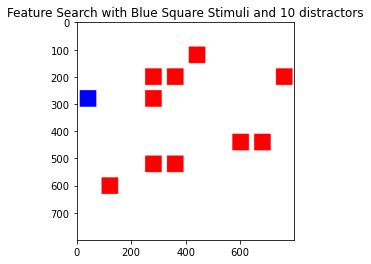

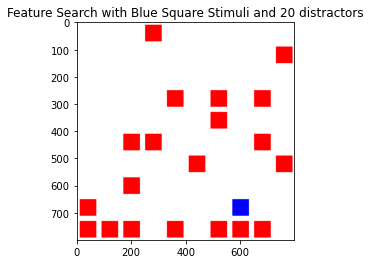

In [50]:
feature_search_image = feature_search_image_generator(number_of_distractors=10)
plt.title("Feature Search with Blue Square Stimuli and 10 distractors")
plt.imshow(feature_search_image)
plt.show()

feature_search_image = feature_search_image_generator(number_of_distractors=20)
plt.title("Feature Search with Blue Square Stimuli and 20 distractors")
plt.imshow(feature_search_image)
plt.show()

This is the image for Feature Search paradigm, we will use this to stimulate the paradigm ahead

- Now we will write a function to generate image for Conjunction search


In [51]:
def conjunction_search_image_generator(stimuli_shape="rectangle", stimuli_color="red", number_of_distractors=20):
    number_of_distractor_pair = int(number_of_distractors/2)
    if stimuli_shape == "rectangle":
        distractor_shape = "triangle"
    else: 
        distractor_shape = "rectangle"
    if stimuli_color == "red":
        distractor_color = "blue"
    else:
        distractor_color = "red"

    conjunction_search_image = get_blank_image()
    grid_points = get_grid_points()

    stimuli_position = grid_points.pop(random.randrange(len(grid_points)))
    drawobj = ImageDraw.Draw(conjunction_search_image)
    if stimuli_shape == "rectangle":
        co_ordinates = get_rectangle_co_ordinates(stimuli_position, 60)
        drawobj.rectangle(co_ordinates, fill=stimuli_color)

    else:
        co_ordinates = get_triangle_co_ordinates(stimuli_position, 60)
        drawobj.polygon(co_ordinates, fill=stimuli_color)

    for i in range(number_of_distractor_pair):
        distractor_position = grid_points.pop(random.randrange(len(grid_points)))
        if distractor_shape == "rectangle":
            co_ordinates = get_rectangle_co_ordinates(distractor_position, 60)
            drawobj.rectangle(co_ordinates, fill=stimuli_color)
        else:
            co_ordinates = get_triangle_co_ordinates(distractor_position, 60)
            drawobj.polygon(co_ordinates, fill=stimuli_color)
        
        distractor_position = grid_points.pop(random.randrange(len(grid_points)))
        

        if stimuli_shape == "rectangle":
            co_ordinates = get_rectangle_co_ordinates(distractor_position, 60)
            drawobj.rectangle(co_ordinates, fill=distractor_color)
        else:
            co_ordinates = get_triangle_co_ordinates(distractor_position, 60)
            drawobj.polygon(co_ordinates, fill=distractor_color)
    return conjunction_search_image

In [52]:
conjunction_search_image = conjunction_search_image_generator()
plt.imshow(conjunction_search_image)
plt.title("Conjunction Search with Red square Stimuli")
plt.show()

# Question 3

- We will now simulate feature integration theory
- In feature integration theory there are 2 stages, 
1) Pre-attentive stage: During this stage, brain automatically gathers information about basic features like color and shape. We as humans are usually not aware of this stage happening.
2) Focussed attention stage: In this stage we combine individual features of object by giving them focussed attention to perceive whole object.

- We will be simulating to implement the preattentive stage
- In this stage, we will check each grid for its color and shape
- For each grid we will store its feature in an list. 
- If the grid is empty, we store "None"

In [53]:
def preattentive_stage(image):
    grid_points = get_grid_points()
    shape_lookup = []
    color_lookup = []
    blue_color ,red_color =(0, 0, 255), (255, 0, 0)
    for idx, point in enumerate(grid_points):
        crop_img = image.crop((point[0]- 40, point[1]-40, point[0] + 40, point[1] + 40))
        gray_crop_img = crop_img.convert("L")
        gray_crop_img = np.asarray(gray_crop_img)

        shape, _ = ComplexCell(gray_crop_img)
        shape_lookup.append(shape)
        
        if shape:
            if crop_img.getpixel((40,40)) == blue_color:
                color_lookup.append("Blue")
            else:
                color_lookup.append("Red")
        
        else:
            color_lookup.append(None)
    return shape_lookup, color_lookup


- Now we visualize feature search
- In feature search, we perceive the image parallely, this is because distractors only vary in single aspect.
- This causes a pop-out effect of the odd stimuli, causing it to be spotted almost instantly
- For implementing feature search here, I will be checking the count of each shape and color
- Either a shape or color will have count 1, this will be our odd stimuli and we will succesfully stimulate the feature search
- Although we know this is not purely parallel search, but since computer is not a human, there will be some serial work involved(unless we implement threading). 
- But for this assignment, we are just simulating the Feature integration theory
- NOTE: Added processing delay of 0.01 secs  

In [54]:
def feature_search(shape_lookup, color_lookup):
    # Feature Search
    start_time = time.time()
    grid_points = get_grid_points()
    rec_count = shape_lookup.count("Rectangle")
    tri_count = shape_lookup.count("Triangle")
    blue_count = color_lookup.count("Blue")
    red_count = color_lookup.count("Red")
    if rec_count == 1:
        target_location = grid_points[shape_lookup.index("Rectangle")]
    elif tri_count == 1:
        target_location = grid_points[shape_lookup.index("Triangle")]
    elif blue_count == 1:
        target_location = grid_points[color_lookup.index("Blue")]
    elif red_count == 1:
        target_location = grid_points[color_lookup.index("Red")]
    
    target_rectangle = (target_location[0]-50, target_location[1]-50,target_location[0]+50, target_location[1]+50) 
    time.sleep(0.01)

    end_time = time.time()
    total_time = end_time - start_time
    return target_rectangle, total_time

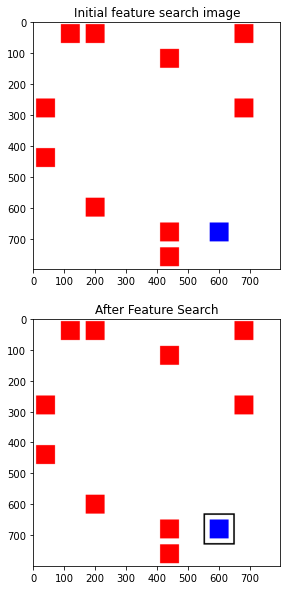

In [55]:
feature_search_image = feature_search_image_generator()
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].set_title("Initial feature search image")
ax[0].imshow(feature_search_image)
shape_lookup, color_lookup = preattentive_stage(feature_search_image)
target_rectangle, total_time = feature_search(shape_lookup, color_lookup)
draw_obj = ImageDraw.Draw(feature_search_image)
draw_obj.rectangle(target_rectangle, width=5, outline="black")

ax[1].set_title("After Feature Search")
ax[1].imshow(feature_search_image)


In [56]:
print("Time taken for search:", total_time)

Time taken for search: 0.017994403839111328


- Now we simulate conjunction search
- In conjunction search, there is no pop out effect, because there are many distractors which differ in feature from odd stimuli
- For implementing this, we will check shape and color of each grid and keep count of each feature combination, my maintaining different list
- There is list for blue rectangles, blue triangles, red rectangles, red triangles.
- Search will conclude, when we loop over all objects, then find the list with length == 1, this will be the odd stimuli
- Conjunction search happens serially
- NOTE: Adding delay of 0.01 secs for processing each grid

In [57]:
def conjunction_search(shape_lookup, color_lookup):
    start_time = time.time()
    grid_points = get_grid_points()
    blue_rec_loc = []
    blue_tri_loc = []
    red_rec_loc = []
    red_tri_loc = [] 

    for i in range(len(shape_lookup)):
        
        shape, color = shape_lookup[i], color_lookup[i]
        if shape: 
            # ADDING A DELAY only when there is a shape in grid
            # This is because humans will search from one object to other not one grid to other
            # so to simulate feature search, we need to add delay of processing a object and not a empty grid
            time.sleep(0.01) 
        if shape == "Rectangle" and color == "Blue":
            blue_rec_loc.append(grid_points[i])
        elif shape == "Triangle" and color == "Blue":
            blue_tri_loc.append(grid_points[i])
        elif shape == "Rectangle" and color == "Red":
            red_rec_loc.append(grid_points[i])
        elif shape == "Triangle" and color == "Red":
            red_tri_loc.append(grid_points[i])

        

    if len(blue_rec_loc) == 1:
        target_location = blue_rec_loc[0]
    elif len(blue_tri_loc) == 1:
        target_location = blue_tri_loc[0]
    elif len(red_rec_loc) == 1:
        target_location = red_rec_loc[0]
    elif len(red_tri_loc) == 1:
        target_location = red_tri_loc[0]

    target_frame = (target_location[0]-50, target_location[1]-50,target_location[0]+50, target_location[1]+50)
    end_time = time.time()
    total_time = end_time - start_time
    return target_frame, total_time


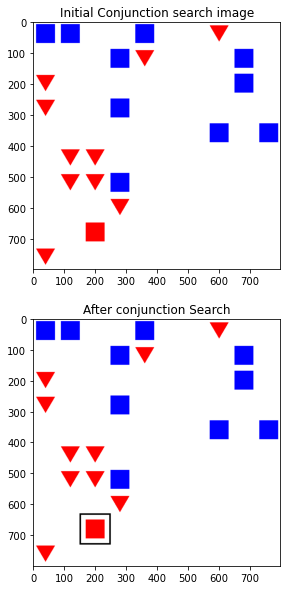

In [58]:
conjunction_search_image = conjunction_search_image_generator()

fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].set_title("Initial Conjunction search image")
ax[0].imshow(conjunction_search_image)
shape_lookup, color_lookup = preattentive_stage(conjunction_search_image)
target_rectangle, total_time = conjunction_search(shape_lookup, color_lookup)
draw_obj = ImageDraw.Draw(conjunction_search_image)
draw_obj.rectangle(target_rectangle, width=5, outline="black")

ax[1].set_title("After conjunction Search")
ax[1].imshow(conjunction_search_image)

In [59]:
print("Time taken for search:", total_time)

Time taken for search: 0.32955360412597656


Time Analysis:<br>
- Now we will analyse response time vs number of distractors for both feature and conjunction search

In [60]:
feature_search_time = []
conjunction_search_time = []

number_of_distractors = range(1,50)


In [61]:
for number_of_distractor in number_of_distractors:
    feature_search_image = feature_search_image_generator(number_of_distractors=number_of_distractor)
    shape_lookup, color_lookup = preattentive_stage(feature_search_image)
    _, total_time = feature_search(shape_lookup, color_lookup)
    feature_search_time.append(total_time)

In [62]:
# Takes approx 30 secs to run
for number_of_distractor in number_of_distractors:
    conjunction_search_image = conjunction_search_image_generator(number_of_distractors=number_of_distractor)
    shape_lookup, color_lookup = preattentive_stage(conjunction_search_image)
    _, total_time = conjunction_search(shape_lookup, color_lookup)
    conjunction_search_time.append(total_time)

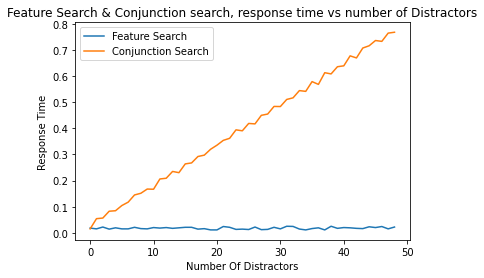

In [63]:
plt.plot(feature_search_time, label="Feature Search")
plt.plot(conjunction_search_time, label="Conjunction Search")
plt.title("Feature Search & Conjunction search, response time vs number of Distractors")
plt.xlabel("Number Of Distractors")
plt.ylabel("Response Time")
plt.legend()
#plt.xticks=(list(range(2,50)),list(range(0,48)))
plt.show()

- Thus we can see that in conjunction search, because there is serial searching, and since we have to place a focused attention over each object, thats why time will also increase linearly with increasing distractors.
- Whereas in feature search, there is parallel searching due to pop-out effect, this helps in near constant time even though number of distractors increase

Acknowledgements 
- My peers Sharanya Saha and Debdeep Paul Chaudhuri were helpful for discussing about the assignment problems